# Predicting Extreme Weather Events using Gradient Boost

WiDS Datathon Overview:

"The WiDS Datathon 2023 focuses on a prediction task involving forecasting sub-seasonal temperatures (temperatures over a two-week period, in our case) within the United States. We are using a pre-prepared dataset consisting of weather and climate information for a number of US locations, for a number of start dates for the two-week observation, as well as the forecasted temperature and precipitation from a number of weather forecast models (we will reveal the source of our dataset after the competition closes). Each row in the corresponds to a single location and a single start date for the two-week period. Your task is to predict the arithmetic mean of the maximum and minimum temperature over the next 14 days, for each location and start date.

You are provided with two datasets:

`train_data.csv`: the training dataset, where `contest-tmp2m-14d__tmp2m`, the arithmetic mean of the max and min observed temperature over the next 14 days for each location and start date, computed as (measured max temperature + measured mini temperature) / 2".
`test_data.csv`: the test dataset, where we withhold the true value of `contest-tmp2m-14d__tmp2m` for each row".

We've done some initial investigation and visualization withing EDA previously and came to the conclusion that the dataset is fairy complicated and there are no obvious clues on how to manually select features without proper domain knowledge. One obvious issue for potential feature selection that we've been able to find is increase of temperatures in the testing set, compared to training set due to climate change. Considering that this issue can cause data drift we are going to try to mitigate this issue using Adversarial Validation. For prediction itself we are going to try using gradient boosting model, which is quite resilient to outliers and overfitting - CatBoost (https://arxiv.org/abs/1810.11363) and for feature selection we are going to apply Bayesian optimization strategy (https://en.wikipedia.org/wiki/Bayesian_optimization).



In [29]:
# Basic imports related to analysis
import pandas as pd
import numpy as np

# Imports for visualisation
import seaborn as sns
from matplotlib import pyplot as plt
import umap.plot

# ML related imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import Pool, cv, CatBoostRegressor
from bayes_optim import BO
import warnings
from sklearn.model_selection import * 
from sklearn.metrics import *
import lightgbm as lgb


# Imports related to preprocessing
from preprocessing import location_nom
from preprocessing import parse_start_date
from preprocessing import categorical_encode
from preprocessing import with_nans

# Silence warnings
import warnings
warnings.filterwarnings("ignore")


## Reading Dataset

Let's start by importing some libraries and loading CSVs into a DataFrames.

In [2]:
# Display all content of the columns
pd.set_option('display.max_columns', None)

# Upload data
train_data = pd.read_csv('datasets/train_data.csv')
test_data = pd.read_csv('datasets/test_data.csv')
# Save target 
target = 'contest-tmp2m-14d__tmp2m'

In [3]:
print(f'Train_shape: {train_data.shape}    |  Test_shape: {test_data.shape}')

Train_shape: (375734, 246)    |  Test_shape: (31354, 245)


In [4]:
# Display part of the trainig set
train_data.head(5)

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-tmp2m-14d__tmp2m,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010

In [5]:
# Display part of the testing set
test_data.head(5)

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,w

## Preprocessing Dataset

During our EDA investigation we've figured out that longitude and latitude values differ for several meters, but can be associated with essentially the same locations. The last digits of fractional parts of some values were different, so we truncated them to 6 digits after coma, so latitude and longitude in training and testing sets match as they, de facto, do. We are going to do the same here as well as create location groups as additional feature for the model. 

In [6]:
# Truncate coordinates and add groups
train_data, test_data = location_nom(train_data, test_data)

# Check location groups
train_data.loc_group, test_data.loc_group

(0           0
 1           0
 2           0
 3           0
 4           0
          ... 
 375729    513
 375730    513
 375731    513
 375732    513
 375733    513
 Name: loc_group, Length: 375734, dtype: int64,
 0          0
 1          0
 2          0
 3          0
 4          0
         ... 
 31349    513
 31350    513
 31351    513
 31352    513
 31353    513
 Name: loc_group, Length: 31354, dtype: int64)

As we've figured out in EDA `NaN` values are present only in the testing set. In EDA we've used previous value to fill the next missing value, but one partecipant find a fifferent solution to it. There are 8 columns with missing values:

In [7]:
with_nans(train_data)

nmme0-tmp2m-34w__ccsm30    15934
nmme-tmp2m-56w__ccsm3      10280
nmme-prate-34w__ccsm3       8738
nmme0-prate-56w__ccsm30    15934
nmme0-prate-34w__ccsm30    15934
nmme-prate-56w__ccsm3      10280
nmme-tmp2m-34w__ccsm3       8738
ccsm30                     15934
dtype: int64

According to the data description: "nmme0-tmp2m-34w": file containing most recent monthly NMME model forecasts for tmp2m (cancm30,cancm40, ccsm30, ccsm40, cfsv20, gfdlflora0, gfdlflorb0, gfdl0, nasa0, nmme0mean) and average forecast across those models (nmme0mean)". 

This means that: `nmme0mean = (missing + cancm30 + cancm40 + ccsm30 + ccsm40 + cfsv20 + gfdlflora0 + gfdlflorb0 + gfdl0 + nasa0) / 9`

So basically we can find missing values like that: `missing = (nmme0mean * 9) - (cancm30 + cancm40 + ccsm40 + cfsv20 + gfdlflora0 + gfdlflorb0 + gfdl0 + nasa0)`

Considering that almost each missing column has associated list of columns that contain similar values and column that contain their mean, we can do this operation for each column from the mising list.


In [8]:
from preprocessing import groups, group_na, group_means

zip_cols = zip(group_na, groups, group_means)
for c, g, m in zip_cols:
    train_data[c] = (train_data[m]*9) - train_data[g].sum(1)

For one column that is left we can apply the old method, used in EDA. 

In [9]:
# Replace each `NaN` with the value that stands right before it
def fill_na(df):
    df = df.sort_values(by=['startdate', 'loc_group']).ffill()
    return df

train_data = fill_na(train_data)

# Check if any `NaN`s are left
with_nans(train_data)

No NaN values found.


In [10]:
parse_start_date(train_data)
parse_start_date(test_data)[:2]

,index,lat,lon,startdate,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,nmme0-tmp2m-34w__cancm40,nmme0-tmp2m-34w__ccsm30,nmme0-tmp2m-34w__ccsm40,nmme0-tmp2m-34w__cfsv20,nmme0-tmp2m-34w__gfdlflora0,nmme0-tmp2m-34w__gfdlflorb0,nmme0-tmp2m-34w__gfdl0,nmme0-tmp2m-34w__nasa0,nmme0-tmp2m-34w__nmme0mean,contest-wind-h10-14d__wind-hgt-10,nmme-tmp2m-56w__cancm3,nmme-tmp2m-56w__cancm4,nmme-tmp2m-56w__ccsm3,nmme-tmp2m-56w__ccsm4,nmme-tmp2m-56w__cfsv2,nmme-tmp2m-56w__gfdl,nmme-tmp2m-56w__gfdlflora,nmme-tmp2m-56w__gfdlflorb,nmme-tmp2m-56w__nasa,nmme-tmp2m-56w__nmmemean,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__cancm4,nmme-prate-34w__ccsm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__gfdlflorb,nmme-prate-34w__nasa,nmme-prate-34w__nmmemean,contest-wind-h100-14d__wind-hgt-100,nmme0-prate-56w__cancm30,nmme0-prate-56w__cancm40,nmme0-prate-56w__ccsm30,nmme0-prate-56w__ccsm40,nmme0-prate-56w__cfsv20,nmme0-prate-56w__gfdlflora0,nmme0-prate-56w__gfdlflorb0,nmme0-prate-56w__gfdl0,nmme0-prate-56w__nasa0,nmme0-prate-56w__nmme0mean,nmme0-prate-34w__cancm30,nmme0-prate-34w__cancm40,nmme0-prate-34w__ccsm30,nmme0-prate-34w__ccsm40,nmme0-prate-34w__cfsv20,nmme0-prate-34w__gfdlflora0,nmme0-prate-34w__gfdlflorb0,nmme0-prate-34w__gfdl0,nmme0-prate-34w__nasa0,nmme0-prate-34w__nmme0mean,contest-slp-14d__slp,contest-wind-vwnd-925-14d__wind-vwnd-925,nmme-prate-56w__cancm3,nmme-prate-56w__cancm4,nmme-prate-56w__ccsm3,nmme-prate-56w__ccsm4,nmme-prate-56w__cfsv2,nmme-prate-56w__gfdl,nmme-prate-56w__gfdlflora,nmme-prate-56w__gfdlflorb,nmme-prate-56w__nasa,nmme-prate-56w__nmmemean,contest-pres-sfc-gauss-14d__pres,contest-wind-uwnd-250-14d__wind-uwnd-250,nmme-tmp2m-34w__cancm3,nmme-tmp2m-34w__cancm4,nmme-tmp2m-34w__ccsm3,nmme-tmp2m-34w__ccsm4,nmme-tmp2m-34w__cfsv2,nmme-tmp2m-34w__gfdl,nmme-tmp2m-34w__gfdlflora,nmme-tmp2m-34w__gfdlflorb,nmme-tmp2m-34w__nasa,nmme-tmp2m-34w__nmmemean,contest-prwtr-eatm-14d__prwtr,contest-wind-vwnd-250-14d__wind-vwnd-250,contest-precip-14d__precip,contest-wind-h850-14d__wind-hgt-850,contest-wind-uwnd-925-14d__wind-uwnd-925,contest-wind-h500-14d__wind-hgt-500,cancm30,cancm40,ccsm30,ccsm40,cfsv20,gfdlflora0,gfdlflorb0,gfdl0,nasa0,nmme0mean,climateregions__climateregion,elevation__elevation,wind-vwnd-250-2010-1,wind-vwnd-250-2010-2,wind-vwnd-250-2010-3,wind-vwnd-250-2010-4,wind-vwnd-250-2010-5,wind-vwnd-250-2010-6,wind-vwnd-250-2010-7,wind-vwnd-250-2010-8,wind-vwnd-250-2010-9,wind-vwnd-250-2010-10,wind-vwnd-250-2010-11,wind-vwnd-250-2010-12,wind-vwnd-250-2010-13,wind-vwnd-250-2010-14,wind-vwnd-250-2010-15,wind-vwnd-250-2010-16,wind-vwnd-250-2010-17,wind-vwnd-250-2010-18,wind-vwnd-250-2010-19,wind-vwnd-250-2010-20,wind-uwnd-250-2010-1,wind-uwnd-250-2010-2,wind-uwnd-250-2010-3,wind-uwnd-250-2010-4,wind-uwnd-250-2010-5,wind-uwnd-250-2010-6,wind-uwnd-250-2010-7,wind-uwnd-250-2010-8,wind-uwnd-250-2010-9,wind-uwnd-250-2010-10,wind-uwnd-250-2010-11,wind-uwnd-250-2010-12,wind-uwnd-250-2010-13,wind-uwnd-250-2010-14,wind-uwnd-250-2010-15,wind-uwnd-250-2010-16,wind-uwnd-250-2010-17,wind-uwnd-250-2010-18,wind-uwnd-250-2010-19,wind-uwnd-250-2010-20,mjo1d__phase,mjo1d__amplitude,mei__mei,mei__meirank,mei__nip,wind-hgt-850-2010-1,wind-hgt-850-2010-2,wind-hgt-850-2010-3,wind-hgt-850-2010-4,wind-hgt-850-2010-5,wind-hgt-850-2010-6,wind-hgt-850-2010-7,wind-hgt-850-2010-8,wind-hgt-850-2010-9,wind-hgt-850-2010-10,sst-2010-1,sst-2010-2,sst-2010-3,sst-2010-4,sst-2010-5,sst-2010-6,sst-2010-7,sst-2010-8,sst-2010-9,sst-2010-10,wind-hgt-500-2010-1,wind-hgt-500-2010-2,wind-hgt-500-2010-3,wind-hgt-500-2010-4,wind-hgt-500-2010-5,wind-hgt-500-2010-6,wind-hgt-500-2010-7,wind-hgt-500-2010-8,wind-hgt-500-2010-9,wind-hgt-500-2010-10,icec-2010-1,icec-2010-2,icec-2010-3,icec-2010-4,icec-2010-5,icec-2010-6,icec-2010-7,icec-2010-8,icec-2010-9,icec-2010-10,wind-uwnd-925-2010-1,wind-uwnd-925-2010-2,wind-uwnd-925-2010-3,wind-uwnd-925-2010-4,wind-uwnd-925-2010-5,wind-uwnd-925-2010-6,w

In [11]:
train_data.startdate.dtype, test_data.startdate.dtype

(dtype('<M8[ns]'), dtype('<M8[ns]'))

In [12]:
train_data.year, test_data.year

(122       2015
 853       2015
 1584      2015
 2315      2015
 3046      2015
           ... 
 372452    2015
 373183    2015
 373914    2015
 374645    2015
 375376    2015
 Name: year, Length: 375734, dtype: int32,
 0        2022
 1        2022
 2        2022
 3        2022
 4        2022
          ... 
 31349    2022
 31350    2022
 31351    2022
 31352    2022
 31353    2022
 Name: year, Length: 31354, dtype: int32)

In [13]:
categorical_encode(train_data, test_data)
train_data.climateregions__climateregion.unique()

array([ 0,  4,  1,  3,  2,  6,  7,  5,  9, 12, 10,  8, 11, 13, 14])

In [14]:
def create_sets(train, test, drop_cols):   
    
    features = [col for col in train.columns if col not in drop_cols]
    X_train = train[features]
    X_test = test[features]
    y_test = train[target]
    
    return X_train, y_test, X_test

X_train, y_test, X_test = create_sets(
    train_data.copy(), 
    test_data.copy(),
    drop_cols = ['index', 'startdate', 'lat', 'lon', target]
    )

## Train and Validation

In [15]:
# Root Mean Squared Error Finder
def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_test, test_size=0.33, random_state=42)
print(f'Train_shape: {X_train.shape}    |   Val_shape: {X_val.shape}    |   Test_shape: {X_test.shape}')

Train_shape: (251741, 245)    |   Val_shape: (123993, 245)    |   Test_shape: (31354, 245)


We've noticed significant change in the training and testing data over time during EDA, what suggests the possibility of a data drift issues in the future, to deal with it we are going to apply adversarial validation technique. With this approach "the system detects concept drift in new data before making inference, trains a model, and produces predictions adapted to the new data".

Adversarial validation is an approach to detect and address the
difference between the training and test datasets

However, if the feature distributions
in the training and test datasets are different (e.,g. see Fig 2), the
performance on the validation and test datasets will be different. In
adversarial validation, a binary classifier, adversarial classifier, is
trained to predict if a sample belongs to the test dataset.

 In adversarial validation,
the predictions of the adversarial classifier are used to help the first
model generalize better with the test data instead

The feature importance and propensity score from the adversar-
ial classifier can be used to detect concept drift between the training
and test data, and provide insights on the cause of the concept drift
such as which features and subsamples in the training data are most
different from ones in the test data.

If distributions of the features from the train and test data are sim-
ilar, we expect the adversarial classifier to be as good as random
guesses. However, if the adversarial classifier can distinguish be-
tween training and test data well (i.e. AUC score ≫ 50%), the top
features from the adversarial classifier are potential candidates ex-
hibiting concept drift between the train and test data. We can then
exclude these features from model training.

In [17]:
# combine train & test features, create label to identify test vs train
labels = np.array([1]*X_train.shape[0] + [0]*X_test.shape[0])
df_master = pd.concat([X_train, X_test])
df_master['labels'] = labels
df_sample = df_master.sample(30000)
labels = df_sample['labels'].values
df_master = df_sample.drop('labels', axis=1)

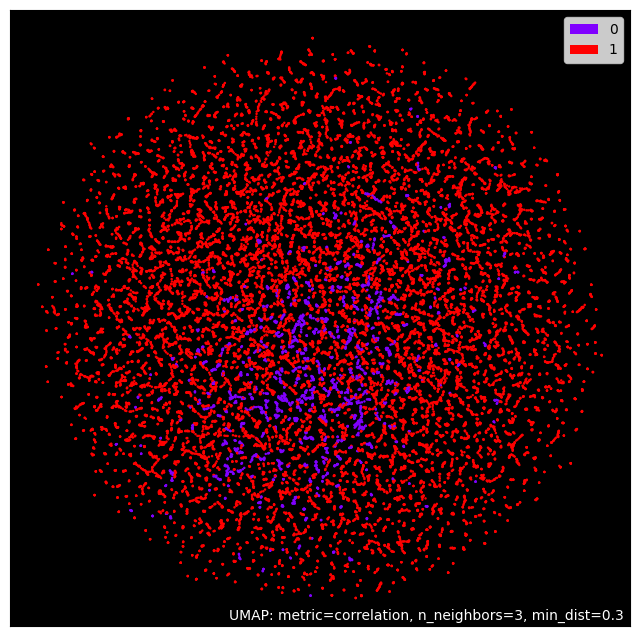

In [18]:
def plot_umap_for_dataset(df_master, labels , n_neighbors=3):
    mapper = umap.UMAP(n_neighbors=n_neighbors,
                      min_dist=0.3,
                      metric='correlation').fit(df_master.values)
    umap.plot.points(mapper, labels=labels, theme='fire')

plot_umap_for_dataset(df_master, labels)

In [20]:

def run_adversial_validation(train_X_ml, test_X_ml):
    
    lgb_params = {'n_estimators':100,
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'verbose': -1,
                'force_col_wise' : 'True'
                }
    
    # combine train & test features, create label to identify test vs train
    ad_y = np.array([1]*train_X_ml.shape[0] + [0]*test_X_ml.shape[0])
    ad_X = pd.concat([train_X_ml, test_X_ml])

    # evaluate model performance using cross-validation
    lgb_data = lgb.Dataset(ad_X, ad_y)
    cv_lgb = lgb.cv(lgb_params, lgb_data)

    print("Adversarial Validation AUC Score: {}".format(cv_lgb['auc-mean'][-1]))
    
    # train model & get feature importance
    ad_val_mod = lgb.train(lgb_params, lgb_data)

    df = pd.DataFrame(
        {'feat':ad_X.columns, 
         'imp':ad_val_mod.feature_importance('split')}).sort_values('imp', ascending = False)   
    
    return ad_val_mod, df

ad_val_mod, imp_df = run_adversial_validation(X_train, X_test)
imp_df

Adversarial Validation AUC Score: 1.0


,feat,imp
0,contest-pevpr-sfc-gauss-14d__pevpr,240
1,nmme0-tmp2m-34w__cancm30,101
242,year,100
2,nmme0-tmp2m-34w__cancm40,36
3,nmme0-tmp2m-34w__ccsm30,32
...,...,...
126,wind-uwnd-250-2010-11,0
127,wind-uwnd-250-2010-12,0
128,wind-uwnd-250-2010-13,0
129,wind-uwnd-250-2010-14,0


In [22]:
X_train.drop(['contest-pevpr-sfc-gauss-14d__pevpr','nmme0-tmp2m-34w__cancm30', 'year'], axis=1,  inplace = True)
X_test.drop(['contest-pevpr-sfc-gauss-14d__pevpr','nmme0-tmp2m-34w__cancm30', 'year'], axis=1, inplace = True)

## Bayesian Optimization for CatBoost

In [25]:
X1, Y1 = X_train.copy(), y_train.copy()

In [27]:
Use_BO = False

if Use_BO:
    #n_estimators,
    # num_leaves
    def CB_opt(depth, learning_rate, subsample, l2_leaf_reg, model_size_reg): 

        scores = []
    #     skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1944)
        trainx, valx, trainy, valy = train_test_split(X1, Y1, test_size=0.33, random_state=42)

        reg = CatBoostRegressor(   
                                        verbose = 0,
                                        #iterations=10,
                                        #n_estimators = 10,
                                        learning_rate = learning_rate,
                                        subsample = subsample, 
                                        l2_leaf_reg = l2_leaf_reg,
                                        max_depth = int(depth),
                                        #num_leaves = int(num_leaves),
                                        random_state = 1212,
                                        #grow_policy = "Lossguide",
    #                                     max_bin = int(max_bin),  
                                        use_best_model = True, 
                                        # bootstrap_type='Bayesian',
                                        loss_function='RMSE',
                                        model_size_reg = model_size_reg
                                    )

        reg.fit(trainx, trainy, eval_set = (valx, valy))
        y_pred = reg.predict(valx)
        scores.append(rmse(valy, y_pred))

        return 1/np.mean(scores)

    #"n_estimators": (150,1200),
    # "num_leaves": (100,150),
    # "max_bin":(150,300),
    pbounds = {
               "depth": (6, 7),
               "learning_rate": (0.09, 0.0980689972639084),
               "subsample":(0.7, 0.800000011920929),
               "l2_leaf_reg":(2,4),
               "model_size_reg": (0.48, 0.5)
    }

    optimizer = BO.BayesianOptimization(f = CB_opt, pbounds = pbounds,  verbose = 2, random_state = 1212)

    optimizer.maximize(init_points = 7, n_iter = 30, acq = 'ucb', alpha = 1e-6)

    print(optimizer.max)

    max_bo_params = optimizer.max['params']

    max_bo_params

Use_BO_result = False

if Use_BO_result:
    opt_params = {
              'iterations':2000,
              'verbose':0,
              'learning_rate' : max_bo_params['learning_rate'],
              'subsample' : max_bo_params['subsample'], 
              'l2_leaf_reg' : max_bo_params['l2_leaf_reg'],
              'max_depth' : int(max_bo_params['depth']), 
              'use_best_model' : True, 
              'loss_function' : 'RMSE',
              'model_size_reg' : max_bo_params['model_size_reg']
             }
else:
    opt_params = {
          'iterations':25000,
          'verbose':0,
          'learning_rate' : 0.0980689972639084,
          'subsample' : 0.7443133148363695, 
          'l2_leaf_reg' : 2.3722386345448316,
          'max_depth' : int(6.599144674342465),
          'use_best_model' : True, 
          'loss_function' : 'RMSE',
          'model_size_reg' : 0.4833187897595954
         }




In [28]:
## catBoost Pool object
train_pool = Pool(data=X1,label = Y1)

X_train, X_test2, y_train, y_test = train_test_split(X1, Y1, test_size=0.33, random_state=42)

bst = CatBoostRegressor(**opt_params)
bst.fit(train_pool, eval_set=(X_test2, y_test), plot=False,silent=True)
print(bst.get_best_score())


{'learn': {'RMSE': 0.09670806025940591}, 'validation': {'RMSE': 0.09678053669505522}}


TBC

References: 
- Adversarial Validation [arXiv:2004.03045v2](https://arxiv.org/abs/2004.03045)
- https://www.kaggle.com/code/kooaslansefat/wids-2023-woman-life-freedom#Bayesian-Optimization-for-CatBoost
- https://www.kaggle.com/code/ducnh279/find-x-correctly-impute-7-8-missing-value-columns